Since softpy is not a Python package available via pip, I manually cloned the GitHub repository and added the relevant folder to Python's module search path.

### Setup repository

In [8]:
!rm -rf softpy

#Cloned the repository
!git clone https://github.com/AndreaCampagner/softpy.git

#Added the root path to sys.path
import sys
sys.path.append("/content/softpy")


Cloning into 'softpy'...
remote: Enumerating objects: 696, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 696 (delta 90), reused 134 (delta 82), pack-reused 512 (from 1)
Receiving objects: 100% (696/696), 23.33 MiB | 25.28 MiB/s, done.
Resolving deltas: 100% (307/307), done.


###Import of classes

In [9]:
#Imported the required classes from the internal modules:
from softpy.evolutionary.candidate import FloatVectorCandidate
from softpy.evolutionary.singlestate import MetaHeuristicsAlgorithm
import numpy as np
import random

This setup allows to use the softpy components (like FloatVectorCandidate) as if they were installed modules, directly inside the Colab environment.


###Definition of ParticleCandidate

In [10]:
class ParticleCandidate(FloatVectorCandidate):
    def __init__(self, size, lower, upper, candidate, velocity,
             inertia=0.5, wl=0.3, wn=0.5, wg=0.2):            #constructor method that initializes all attributes of the particle


        assert abs(wl + wn + wg - 1.0) < 1e-6, "Weights must sum to 1"        #test if wl + wn + wg - 1.0 < 0.000001 (checks if the absolute difference is less than a very small number)
      #I haven't used (wl + wn + wg ) == 1.0 because if dealing with decimals number this method can rise to imprecisions

        self.size = size        #dimensionality of the candidate vector
        self.lower = lower      #lower bounds for each component
        self.upper = upper      #upper bounds for each component
        self.candidate = candidate  #position of the particle
        self.velocity = velocity    #velocity of the particle
        self.inertia = inertia    #inertia weight
        self.wl = wl            #weight for personal best
        self.wn = wn            #weight for neighborhood best
        self.wg = wg            #weight for global best

        super().__init__(size=size, candidate=candidate, distribution=None, lower=lower, upper=upper)   #initialization

    @staticmethod         #generates a new particle with random position and velocity within the given bounds
    def generate(size, lower, upper, inertia=0.5, wl=0.3, wn=0.5, wg=0.2):
        candidate = np.random.uniform(lower, upper)
        range_ = np.abs(upper - lower)
        velocity = np.random.uniform(-range_, range_)
        return ParticleCandidate(size, lower, upper, candidate, velocity, inertia, wl, wn, wg)

    def mutate(self):     #updates the particle's position by adding its velocity
        self.candidate += self.velocity
        overflow_low = self.candidate < self.lower
        overflow_high = self.candidate > self.upper
        self.candidate[overflow_low] = self.lower[overflow_low] + (self.lower[overflow_low] - self.candidate[overflow_low])
        self.candidate[overflow_high] = self.upper[overflow_high] - (self.candidate[overflow_high] - self.upper[overflow_high])
        #applies boundary correction if the new position exceeds the defined limits

    def recombine(self, local_best, neighbor_best, global_best):  #updates the particle's velocity based on the influence of its personal best neighborhood best, and the global best positions
        rl = np.random.uniform(0, 1, size=self.size)
        rn = np.random.uniform(0, 1, size=self.size)
        rg = np.random.uniform(0, 1, size=self.size)

        #compute the three components of velocity update
        personal = self.wl * rl * (local_best.candidate - self.candidate)
        neighborhood = self.wn * rn * (neighbor_best.candidate - self.candidate)
        global_ = self.wg * rg * (global_best.candidate - self.candidate)

        #update velocity
        self.velocity = self.inertia * self.velocity + personal + neighborhood + global_

###Definition of PSO


Particle Swarm Optimizer implementing a population-based metaheuristic.
Each particle updates its position based on personal best, neighborhood best, and global best.

fit method executes the PSO optimization process for a number of iterations.

In [11]:
class ParticleSwarmOptimizer(MetaHeuristicsAlgorithm):
    def __init__(self, candidate_type, fitness_func, pop_size, n_neighbors, **kwargs):
        super().__init__(candidate_type, fitness_func)

        self.candidate_type = candidate_type      #class used to generate candidates
        self.fitness_func = fitness_func          #fitness function to evaluate candidates
        self.pop_size = pop_size                  #number of particles in the swarm
        self.n_neighbors = n_neighbors            #number of neighbors per particle
        self.kwargs = kwargs

        #initialize population and tracking variables
        self.population = []                      #list of ParticleCandidate instances
        self.best = [None] * pop_size             #best known position for each particle
        self.fitness_best = np.full(pop_size, -np.inf)   #best fitness value for each particle
        self.global_best = None                   #best position found in the entire swarm
        self.fitness_global_best = -np.inf        #best fitness value found globally

    def fit(self, n_iters=10, keep_history=False):
        #recover key hyperparameters
        size = self.kwargs["size"]
        lower = self.kwargs["lower"]
        upper = self.kwargs["upper"]
        inertia = self.kwargs.get("inertia", 0.5)
        wl = self.kwargs.get("wl", 0.3)
        wn = self.kwargs.get("wn", 0.5)
        wg = self.kwargs.get("wg", 0.2)

        #generate the initial population
        self.population = [
            self.candidate_type.generate(size, lower, upper, inertia, wl, wn, wg)
            for _ in range(self.pop_size)
        ]

        if keep_history:
            self.best_h = np.empty(n_iters, dtype=object)
            self.fitness_h = np.zeros(n_iters)

        for it in range(n_iters):           #optimization loop
            for i, particle in enumerate(self.population):
                fitness = self.fitness_func(particle)

                #update personal best
                if fitness > self.fitness_best[i]:
                    self.fitness_best[i] = fitness
                    self.best[i] = particle

                #update global best
                if fitness > self.fitness_global_best:
                    self.fitness_global_best = fitness
                    self.global_best = particle

            if keep_history:
                self.best_h[it] = self.global_best
                self.fitness_h[it] = self.fitness_global_best

            #update all particles using neighbors and bests
            for i, particle in enumerate(self.population):
                neighbors = random.sample(
                    [j for j in range(self.pop_size) if j != i],
                    min(self.n_neighbors, self.pop_size - 1)
                )
                #identify best neighbor
                best_neighbor_idx = max(neighbors, key=lambda j: self.fitness_best[j])
                neighbor_best = self.best[best_neighbor_idx]

                #update particle velocity and position
                particle.recombine(self.best[i], neighbor_best, self.global_best)
                particle.mutate()

        #save final besst candidate
        self.best = self.global_best
        self.fitness_best = self.fitness_global_best
        self.is_fitted = True
        return self.global_best


###Fitness function

The sphere function is a common benchmark used in optimization and evolutionary algorithms.
It is a smooth, convex, and unimodal function defined as: $$f(x) = \sum_{i=1}^{n} x_i^2$$
In this case I put the minus sign because the aim is to let the optimizer maximize and find the closest point to origin:  $$f(x) = -\sum_{i=1}^{n} x_i^2$$

In [12]:
def sphere_function(candidate):
    return -np.sum(candidate.candidate ** 2)

###Algorithm execution

In [13]:
# definition of the Particle Swarm Optimizer
optimizer = ParticleSwarmOptimizer(
    candidate_type=ParticleCandidate,
    fitness_func=sphere_function,
    pop_size=20,             #number of particles in the swarm
    n_neighbors=5,           #number of neighbors used in local best
    size=10,                 #dimension of the search space
    lower=np.full(10, -5),   #lower bounds
    upper=np.full(10, 5),    #upper bounds
    inertia=0.5,             #inertia weight
    wl=0.3,                  #weight for personal best
    wn=0.5,                  #weight for neighborhood best
    wg=0.2                   #weight for global best
)

# execution of optimization process
best = optimizer.fit(n_iters=20, keep_history=True) #num of iteration

# output and final results
print("Best fitness:", optimizer.fitness_best)
print("Best position:", optimizer.best.candidate)


Best fitness: -4.93805597371517
Best position: [ 0.5538086  -3.63946725  1.49013382  1.12324842  3.02191301  1.56506139
 -0.98635452  0.16502157 -0.15697689  0.82075114]


###Visualization

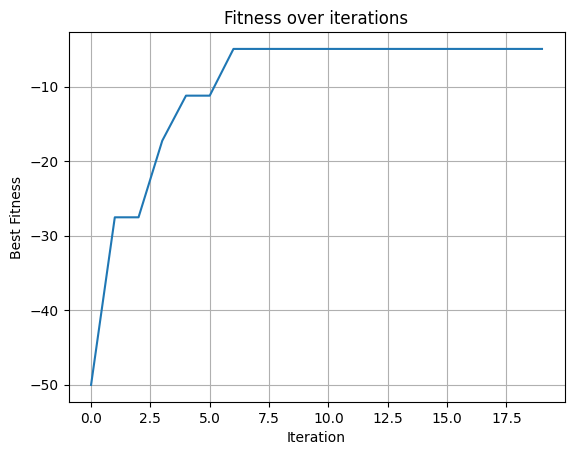

In [14]:
import matplotlib.pyplot as plt

plt.plot(optimizer.fitness_h)
plt.title("Fitness over iterations")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness")
plt.grid(True)
plt.show()

##Final result
The algorithm returns the best solution (position) found and its corresponding fitness value.

###Note
Result may vary between runs due to the stochastic nature of PSO.
To obtain repeatable results, it would be enough to fix a seed in the random generation

    np.random.seed(42)
    random.seed(42)